In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm 

from qiskit import  QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.circuit.library import QFT
from qiskit.circuit.library import RYGate

from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem

# Functions


In [2]:
def Measure(qc,n2,n1=0, shots=1024, reverse=False):
    meas = QuantumCircuit(n2-n1, n2-n1)
    meas.barrier(range(n1,n2))
    # map the quantum measurement to the classical bits
    if reverse:
        meas.measure(range(n), reversed(range(n)))
    else:
        meas.measure(range(n1,n2), (range(n1,n2)))

    circ = qc.copy()
    circ.add_register(meas.cregs[0])
    circ = circ.compose(meas)
    print(circ.draw('mpl'))
    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    job_sim = backend_sim.run(transpile(circ, backend_sim), shots=shots)

    # Grab the results from the job.
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    
    return counts#,circ


def calc_high_low(S0, r, vol, m,T,L):
    '''
    Determine the domain of the discretization of the asset price.
    Uses 3 standard deviations from the mean to detrmine low/high. 
    The step size is then given by dx=(high−low)/(2^m−1)
    
    Args:
        S0: Current price of asset
        r: Interest rate 
        vol: Volatility
        m: Number of qubits
        T: Maturity in years
        L: Number of averaging steps
        
    Returns:
        low, high, dx
    '''
    
    #m = 2 # number of qubits for each steps (in total mL qubits are needed)
    N = 2**m
    dt = T/L

    mu = (r - 0.5 * vol**2) * dt + np.log(S0)
    sigma = vol * np.sqrt(dt)
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    # lowest and highest value considered for the spot price; 
    #in between, an equidistant discretization is considered.
    low = np.maximum(0, mean - 3 * stddev)
    high = mean + 3 * stddev
    dx = (high - low) / (N - 1)
    
    return low,high, dx

def generate_pdf(x, S,r,sigma,dt):
    '''
    Evaluate the pdf of a lognormal distribution 
    with S the previous price of the asset

    Args:
        x: Point at which the pdf is evaluated
        S: Current price of asset
        r: Interest rate 
        sigma: Volatility
        dt: time difference between two averaging steps
        
    Returns:
        p(x)
    '''
    
    mu = np.exp((r-0.5*sigma**2)*dt + np.log(S))
    sigma = sigma*np.sqrt(dt)
    return lognorm.pdf(x,s = sigma, scale= mu)

def generate_initial_prob(S0, r, sigma,dt,m, L):
    '''
    Calculates the probabilities p =p1*p2*...*pL
    For each path \vec{S} = [S1,S2,...,SL]
    The discritization is kept contant while the probablities,
    vary with each time step.

    Args:
        S0: Current price of asset
        r: Interest rate 
        sigma: Volatility
        dt: time difference between two averaging steps
        m: Number of qubits
        L: Number of averaging steps
        
    Returns:
        S: Discretization of one time step
        p: Probabilities p =p1*p2*...*pL
    '''
    N = 2**m
    low,high,dx = calc_high_low(S0,r,sigma,m,dt*L,L)
    S = []
    p = []
    for i1 in range(N):
        S1 = low + dx*i1
        S.append(S1)
        p1 = generate_pdf(S1, S0, r, sigma,dt)
        if L == 1:
            p.append(p1)
        else:
            for i2 in range(N):
                S2 = low + dx*i2
                p2 = generate_pdf(S2, S1, r, sigma,dt)
                if L == 2:
                    p.append(p1*p2)
                else:
                    for i3 in range(N):
                        S3 = low + dx*i3
                        p3 = generate_pdf(S3, S2, r, sigma,dt)
                        if L == 3:
                            p.append(p1*p2*p3)
                        else:
                            print('Max L is 3 for now...')
                       
    p = np.array(p) / np.sum(p)
    return S,p


def p_subnorm(p, k,m):
    '''
    Sum the discrite probabilties from k*2^(n-m) till (k+1)*2^(n-m)
    '''
    return np.sum(p[k*2**(n-m):(k+1)*2**(n-m)]) # j=k2^(n−m) till (k+1)2^(n−m)−1 
def f(p,k,m):
    '''
    Fraction of two subsequent subnorms:
    f(k,m) = p_{2k}^{(m+1)}/p_{k}^(m).
    ''' 
    return p_subnorm(p,2*k,m+1)/p_subnorm(p,k,m)
def theta(p,k,m):
    '''
    \theta = arccos(\sqrt{f(k,m)})
    '''
    return 2*np.arccos(np.sqrt(f(p,k,m)))

def add_one_layer_probs(qc, p, n, m):
    '''
    See Appendix E of:
    Rebentrost, P., Gupt, B., &#38; Bromley, T. R. (2018). Quantum computational finance: Monte Carlo pricing of financial derivatives.
    https://doi.org/10.1103/PHYSREVA.98.022321/FIGURES/4/MEDIUM
    
    Prepares on qubit at a time in the desired probability distribution.
    Start with  the most significant and moves down.
    
    (note that the circuit can be optimized due to unessesary X-gates.)
    
    Args:
        qc: QuantumCircuit
        p: Discrete probability distribution (from generate_initial_prob)
        n: total number of qubits
        m: the qubit to rotate next
    '''
    
    for i in reversed(range(2**m)):
        for j, s in enumerate(np.binary_repr(i,width=m)):
            if s == '0' :
                qc.x(n-1-j)
                
        qc.append(RYGate(theta(p,i,m)).control(m), list(reversed(range(n-m-1,n))))
                  
        for j, s in enumerate(np.binary_repr(i,width=m)):
            if s == '0' :
                qc.x(n-1-j)
    return qc

# Pricing Asian option with Quantum MC

In this notebook we follow closely the steps taken in: [Fx Asian Option Pricing using Quantum Computers. Pracht, R. 2022.](https://ssrn.com/abstract=4137397)


We aim to price an Asian call option based on the arithmetic mean.
The stochastic process that the asset follows is given by
$$dS_t = S_trdt + S_t\sigma dW_t$$
The process is for now assumed to have constant $r$ and $\sigma$. The arithmetic mean is given by:
$$A_T = \frac{1}{L}\sum_{i=1}^L S_{t_i}$$
where L is the number of averaging points, and $0< t_1 \leq \dots\leq t_L = T$. We assume equidistant timing: $t_{i+1} - t_{i} = \Delta t$  is constant.
The last time step is set equal to the maturity of the option. Furthermore, the first time step is not taken to be $t_1=0$ but $\Delta t$. This is done since at that time the asset price $S_0$ is already known and doesn't need simulating. In case it needs to be included it can be added in the calculation of the payoff and doesn't need its own register.

The option we price has a payoff given by:
$$f(A_T) = max\{0,A_T-K\} $$

In [3]:
# Set-up parameters
T = 1 #year
S0 = 100
K = 100
r = 0.05
vol = 0.2

#Determine number of qubits (keep low ~2/3 for computability)
L = 2 # number of averaging steps
m = 3 # number of qubits for each steps (in total mL qubits are needed)
dt = T/L
N = m**2

Here we calculate the price using (classical) monte Carlo simulation. Euler integration method for the stochastic process is used. Other variation of MC can be used,
such as variate control, to improve accuarcy.

The expected discounted payoff can be calculated by
$$
\mathbb{E_Q}(f(A_T)) \approx \hat{V}_0^M=e^{-rT} \cdot \frac{\sum_{i=1}^M f\left(A_T^{(i)}\right)}{M}
$$

In [4]:
N_sim = 10000
S = np.zeros((L+1,N_sim))
S[0] = S0
phi = np.random.normal(size=(L,N_sim))
for n in range(L):
    S[n+1] = S[n] + S[n]*(r*(T/L) + vol*np.sqrt(T/L)*phi[n])
    
_payoffs = np.exp(-r*T)*np.maximum(np.mean(S[1:],axis=0) - K,0)
exact_price = np.mean(_payoffs)

print('Exact price is:', exact_price)
print('Standard error is:', np.std(_payoffs)/np.sqrt(N_sim)) 

Exact price is: 8.06085586546213
Standard error is: 0.1046313721789418


## 1. Loading the uncertainty model (PDF)

Goal is to obtain the total product state for the $L$ steps. This is given by:
$$
\sum_{I_1=0}^{2^m-1} \sum_{I_2=0}^{2^m-1} \cdots \sum_{I_{L}=0}^{2^m-1} \sqrt{p_{I_1, I_2, \ldots, I_M}}\left|I_1\right\rangle_m\left|I_2\right\rangle_m\dots\left|I_M\right\rangle_m
$$
Here $\left|I_M\right\rangle_m$ indicates the register of one timestep, with corresponing probability $p_{I_1}$ associated with that step.

The stock price from the discrete qubits is obtained from the mapping $\Delta *I_j +low \in[low,high]$, where $low = \mu -3\sigma$, and  $high = \mu + 3\sigma$ and $\Delta= \frac{high−low}{2^m−1}$, and $I_j \in\{0,1,\dots,2^{m-1}\}$

In [5]:
S,p = generate_initial_prob(S0,r,vol,dt,m,L)
amplitudes = np.sqrt(p) #Amplitude of the quantum state, (sqaure root of probability)
n_adj = m + int(np.ceil(np.log2(L))) #Number of bits for the last register, bigger than m to store the mean.

num_qubits = (L-1)*m + (n_adj) * 2 + 1 #Total number of qubits 
regs = [QuantumRegister(m) for i in range(L-1)] #Give each time step its own register
regs.append(QuantumRegister(2*n_adj + 1)) #Last register with more qubits

asian_call = QuantumCircuit(*regs)

In [6]:
n = m*L #number of qubits needed for initializing the probability function
qc = QuantumCircuit(n)

qc.ry(2*np.arccos(np.sqrt(p_subnorm(p,0,1))), n-1)

#iterate from most to least significant bit loading more of the probability each step
for i in range(1,n):
    qc = add_one_layer_probs(qc,p,n,i)

P_loading = qc.to_gate(label='P(x)')

asian_call.append(P_loading,range(n))
#qc.draw('mpl') 

As an ilustartion, the probability discretization of the first time step of the assest is plotted below. The mapping to the qubits is also given at the top of each bar.

Text(0.5, 1.0, 'The discretization of the first time step')

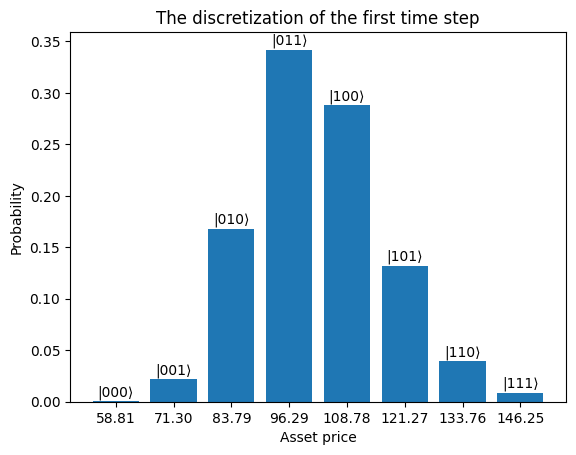

In [7]:
low,high,dx = calc_high_low(S0,r,vol,m,T,L)
x = np.arange(low,high+dx,dx)
p_one = generate_pdf(x,S0,r,vol,T/L)
p_one = p_one/np.sum(p_one)
plt.bar([f'{xi:.2f}' for xi in x], p_one, width = 0.8)
for i in range(len(x)):
    plt.text(i, p_one[i]+0.005, f'|{np.binary_repr(i,width=m)}⟩', ha = 'center')
plt.xlabel('Asset price')
plt.ylabel('Probability')
plt.title('The discretization of the first time step')

We can calculate the option price from the given probability distribution by calculating the payoff of each path multiplied by its probability.
$$
\sum_{I_1 \ldots I_L=0}^{2^m-1} p_{I_1, \ldots, I_L} f\left(A\left(S_{t_1}\left(x_{I_1}\right), \ldots, S_{t_L}\left(x_{I_L}\right)\right)\right) \approx \mathbb{E}_{\mathbb{Q}}[f(A)]
$$

This gives the option price with an error due only to the discritization. (There is no measurement error in the step below)

In [8]:
#Calculate from initial probabilities
S_path = []
for i in range(2**m):
    for j in range(2**m):
        S_path.append([S[i],S[j]])
discretized_price = np.sum(np.maximum(np.mean(S_path,axis=1) - K,0) * p)
print('Option prices after discritazation', discretized_price)

Option prices after discritazation 7.575364811545528


Figure(807.394x1120.39)


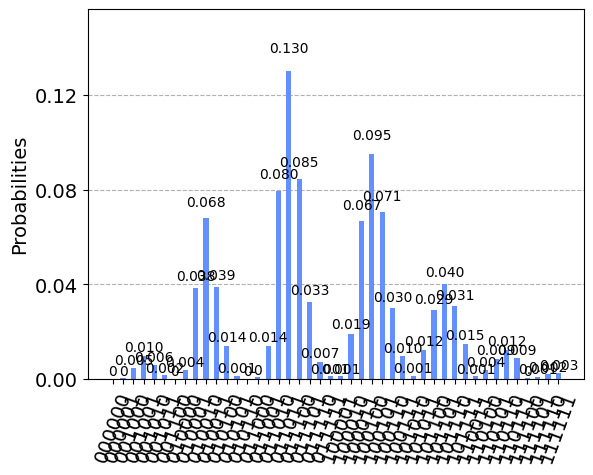

Option prices from statevector 7.710472563142896


In [9]:
#Calculate form state vector simulations, to check the loading circuit
# This also includes measurment error from finite number of shots
fig ,ax = plt.subplots(1,1)
counts = Measure(asian_call,m*L, shots=10000, reverse=False)
plot_histogram(counts,ax=ax)
plt.show()

S_all = []
for key in counts.keys():
    _S = []
    for i in range(L):
        _S.append(S[int(key[m*i:m*(i+1)],2)])
    S_all.append(_S)
S_all = np.array(S_all)
p_sample = np.array(list(counts.values()))/np.sum(list(counts.values()))
print('Option prices from statevector', np.sum(np.maximum(np.mean(S_all,axis=1) - K,0) * p_sample))

## 2. Adding of the asset prices

Next step is to add the value of each register together and save it on the last register.

This can be achieved trough an QFT, then controlled rotations in the frequency domain and then iQFT back.
QFT is defined as:
$$
|\phi(x)\rangle=\mathrm{QFT}|x\rangle=\frac{1}{N} \sum_{k=0}^{N-1} e^{i \frac{2 \pi x k}{N}}|k\rangle
$$
The rotations in the Fourier domain will then add the indexes together:
$$
\{0, \ldots, M-1\} \ni t \mapsto e^{2 \pi i \frac{\left(I_{M, j}+I_{t, j}\right) 2^{\tilde{N}-j_k} 2_s \bar{N}+1-s}{2^N+1}}=e^{2 \pi i \frac{\left(I_{M, j}+I_{t, j}\right) k_s}{2 j+s-N}}
$$
Transforming back with iQFT will give the summation result on the last register. 

Note that there is no need to do the swap operations of the QFT since it will be swapped back by IQFT and we can adjust our rotations in between accordingly.

The final state we obtain for the last register with $\tilde{N} = 2^{(m+\log_2{L})}$ is 
$$
\sum_{j=0}^{\tilde{N}-1} \sqrt{p_j}\left|j\right\rangle, \quad S_j=L*\operatorname{low}+\Delta * j .
$$
Here we only summed the values together and did not take the mean. We instead will compare the value against $L*K$ later on. This is different then done in 
 [Fx Asian Option Pricing using Quantum Computers. Pracht, R. 2022.](https://ssrn.com/abstract=4137397)

In [10]:
asian_call.append(QFT(n_adj, do_swaps=False), range((L-1)*m, (L-1)*m + n_adj))

for t in range(L-1):
    for j in range(m):
        idx = 0
        for i in range(j, n_adj):
            asian_call.cp(2*np.pi/2**(idx+1), regs[t][j], regs[L-1][i])
            idx += 1
            
asian_call.append(QFT(n_adj, do_swaps=False, inverse=True), range((L-1)*m, (L-1)*m + n_adj))

{'1000': 1328, '1100': 255, '0101': 1315, '0111': 1691, '1010': 789, '0110': 1621, '0100': 891, '1011': 506, '1001': 1099, '0011': 430, '1101': 100, '0010': 150, '1110': 20, '0001': 41, '0000': 4}


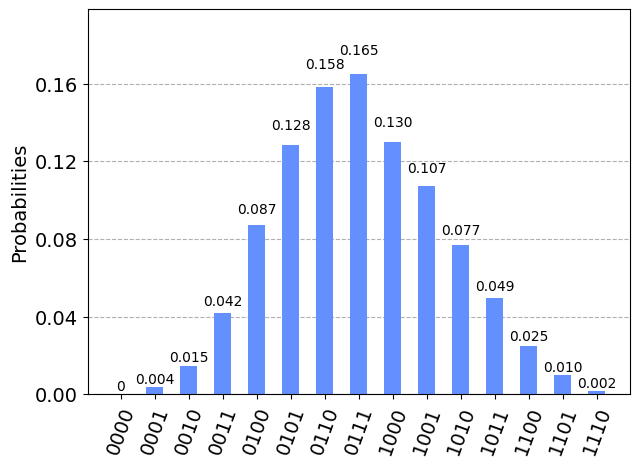

In [11]:
circ = asian_call.copy()
cl = ClassicalRegister(n_adj)
circ.add_register(cl)
circ.measure(regs[-1][:n_adj],cl)
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(circ, backend_sim), shots=10240)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
print(counts)
plot_histogram(counts)

In [12]:
#Calculate option price from the mean obtained from the measurments above.
#This shows that the calculation of the mean works

#The range is now larger due to the extra qubits, the dx is still the same as is low
low,high,dx = calc_high_low(S0,r,vol,m,T,L)
new_S = [L*low + i *dx for i in range(n_adj**2)]

new_counts  = {}
for key in counts.keys():
    new_counts[new_S[(int(key,2))]] = counts[key]
#plot_histogram(new_counts)

temp_payoff = 0
for key,val in new_counts.items():
    A= np.maximum(key - L*K, 0 ) * val/sum(list(new_counts.values()))
    temp_payoff += A
print('Price calculated from statevector after mean operation', temp_payoff/L)

Price calculated from statevector after mean operation 7.48859287227895


## 3. Calculate the payoff 
The next step is to calculate the payoff function from the mean. The payoff function

is the same as for an European call option, except now on the mean $A(T,L)$. 
(See the tutorial for more detail: [Qiskit European Call option](https://qiskit.org/documentation/finance/tutorials/03_european_call_option_pricing.html)

For this we use a picewise linear function also used for the pricing of European option. This is readiliy available from Qiskit.
It sets an additional qubit to the state:
$$
\sum_{j=0}^{\tilde{N}-1} \sqrt{p_j} \sqrt{1-f_j}|0\rangle+\sum_{j=0}^{\tilde{N}-1} \sqrt{p_j} \sqrt{f_j}|1\rangle
$$
where 
$$
f(j)=\left\{\begin{array}{ll}
0 & j<KL \\
S_j-\text { Strike} & j \geq KL
\end{array}=\left\{\begin{array}{ll}
0 & j<KL \\
\text { L*low }+\Delta j -\text { Strike } & j \geq KL
\end{array}= \begin{cases}0 & j<KL \\
f_{\min }+\Delta j & j \geq KL\end{cases}\right.\right.
$$ 
and $f_{max} = \Delta*(\tilde{N}-1)$. This gives the possible image of the payoff $[f_{min}, f_{max}]$

Measuring the ancilla qubit in state 1 gives as probability the payoff, namely $\sum_{j=0}^{\tilde{N}-1} p_jf_j = \mathrm{E}[P_{call}]$.

#

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K$ and then increases linearly.
The implementation uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K$, and this ancilla is used to control the linear part of the payoff function.

The linear part itself is then approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation rescaling factor $c_\text{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_\text{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_\text{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_\text{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, see:
[Quantum Risk Analysis. Woerner, Egger. 2018.](https://www.nature.com/articles/s41534-019-0130-6)

In [13]:
# set the strike price (should be within the low and the high value of the uncertainty)
N_mean = L
strike_price = K*N_mean

low, high, dx = calc_high_low(S0, r, vol, m,T,L)
low = L * low
high = low + dx * (2**n_adj - 1)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective function
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
asian_call_objective = LinearAmplitudeFunction(
    n_adj,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)
asian_call.append(asian_call_objective, range((L-1)*m , num_qubits))

In [14]:
circ = asian_call.copy()
cl = ClassicalRegister(1)
circ.add_register(cl)
circ.measure(regs[-1][n_adj],cl)
backend_sim = Aer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator.
job_sim = backend_sim.run(transpile(circ, backend_sim), shots=102400)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
print(counts)

{'0': 65475, '1': 36925}


## 4. Post process
The last step is to post process the result. This requires us to map the outcome of the measurement to the corresponding payoff value.
This is done by considering the domain of the payoff function. (Note that Qiskit has this step build into the LinearAmplitudeFunction(.)
$$
\text { price }=f_{\max } \left( \frac{p-\frac{1}{2}}{c\frac{\pi}{2}}+\frac{1}{2} \right) \text {. }
$$

In [15]:
# post process
val = (counts['1']/102400)
# revert the mapping applied in the Taylor approximation
val = val - 0.5 + np.pi/4 * c_approx
val *= 2/np.pi/c_approx
# map the value from [0, 1] back to the original domain
val *= (f_max-f_min)
val += f_min
print(val/L)

7.612425150098634


# Amplitude Estimation
In the above steps we have shown how to construct the circuit and saw despite the discritization and measurment errors that the outcome was close to the price.

Since we have all the elements of the circuit we can conduct iterative Amplitude estimation as the last step to acuratly obtain the probability from the target qubit.

For this we use the build in methods of Qiskit

In [16]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=200)
problem = EstimationProblem(
    state_preparation=asian_call,
    objective_qubits=[(L-1)*m + n_adj],
    post_processing=asian_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [17]:
result = ae.estimate(problem)

In [18]:
conf_int = np.array(result.confidence_interval_processed)
#print("Exact value:        \t%.4f" % exact_value)
print("Price from MC:               \t%.4f" % exact_price)
print("Price after discritization:  \t%.4f" % discretized_price)
print("Estimated value:             \t%.4f" % (result.estimation_processed/L))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int/L))

Price from MC:               	8.0609
Price after discritization:  	7.5754
Estimated value:             	7.9939
Confidence interval:	[7.3973, 8.5905]
